## Configure environment

In [ ]:
import random
import time
import os
import datetime
import itertools
import math
import sys
from random import randint
import shutil

In [ ]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [ ]:
if IN_COLAB:
  COLAB_BASE_DIR = "/content/gdrive/MyDrive/Universidad/VIU/TFM/notebooks/"
  from google.colab import drive
  drive.mount('/content/gdrive/')
  sys.path.append(os.path.join(COLAB_BASE_DIR, 'ConvLSTM'))
  sys.path.append(os.path.join(COLAB_BASE_DIR, 'common'))

Mounted at /content/gdrive/


In [ ]:
if IN_COLAB:
  if not os.path.exists("/data/masked_clouds.hdf5"):
    %mkdir -p /data
    shutil.copyfile(os.path.join(COLAB_BASE_DIR, "common/masked_clouds.hdf5"), "/data/masked_clouds.hdf5")

In [ ]:
%%capture
%pip install torch torchvision h5py xarray matplotlib

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.v2 as v2
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.utils.data as data
from torch.utils.data import DataLoader
import numpy as np
import h5py
import PIL.Image
from IPython.core import display as idisplay
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import xarray as xr

import ConvLSTMmodels
if not IN_COLAB:
  sys.path.append('../common')
import common

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
if not IN_COLAB:
  common.set_memory_limit_if_not_limit(1.5)

In [ ]:
os.makedirs('save', exist_ok=True)

## Load data

In [ ]:
cwd = os.getcwd()
pardir = os.path.dirname(os.path.dirname(cwd))
data_folder = os.path.join(pardir,'data')
data_path = os.path.join(data_folder, 'masked_clouds.hdf5')
model_name = 'MaskedConvLSTM'
output_path = os.path.join(cwd, "save", f"{model_name}.torch")
if IN_COLAB:
  output_path = os.path.join(COLAB_BASE_DIR, "ConvLSTM", f"{model_name}.torch")
with h5py.File(data_path, 'r') as fds:
    group_names = list(fds.keys())
    print(group_names)
    fds.close()


dss = {}
for gname in group_names:
    dss[gname] = xr.open_dataset(data_path, engine='h5netcdf', group=gname, phony_dims='sort')

['test', 'trainval']


In [ ]:
print(dss['test']['images_log'])
print(dss['test']['images_log'].shape)

<xarray.DataArray 'images_log' (phony_dim_0: 4467, phony_dim_1: 16,
                                phony_dim_2: 64, phony_dim_3: 8, phony_dim_4: 5)> Size: 183MB
[182968320 values with dtype=uint8]
Dimensions without coordinates: phony_dim_0, phony_dim_1, phony_dim_2,
                                phony_dim_3, phony_dim_4
(4467, 16, 64, 8, 5)


# Processing data

## Dataloaders

In [ ]:
bs = 24 # batch size
transform = transforms.Compose([
    transforms.Lambda(lambda x: np.unpackbits(x, axis=1)),
    torch.from_numpy,
    transforms.Lambda(lambda x: torch.permute(x, (2, 0, 1)).float()),
])
# Create Dataset and DataLoader
train_dataset = common.VideoDataset(dss['trainval']['images_log'], dss['trainval']['images_pred'], transform=transform, stack_videos=False, device=device)
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=False)


transform = transforms.Compose([
    transforms.Lambda(lambda x: np.unpackbits(x, axis=1)),
    torch.from_numpy,
    transforms.Lambda(lambda x: torch.permute(x, (2, 0, 1)).float()),
])
test_dataset = common.VideoDataset(dss['test']['images_log'], dss['test']['images_pred'], transform=transform, stack_videos=False, device=device)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

print(f"Number of videos: {len(train_dataset.videos)}.")
print(f"Number of video batches: {len(train_loader)}")
print(f"Size of video batches: {bs}.")


Number of videos: 53336.
Number of video batches: 2223
Size of video batches: 24.


## Printer

In [ ]:
cmap = mcolors.ListedColormap(['black', 'cyan', 'yellow', 'white', 'blue'], 'CloudSegmenter')

torch.Size([5, 64, 64])
torch.Size([64, 64])
[0 1 2]


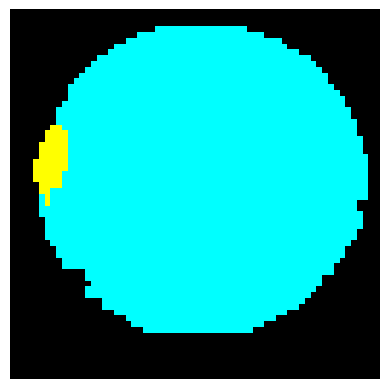

In [ ]:
testim = next(iter(train_loader))[0][1][0]
print(testim.shape)
testim = torch.argmax(testim, dim=0).cpu()
print(testim.shape)
print(np.unique(testim))
plt.axis('off')
plt.imshow(testim, cmap=cmap, vmin=0, vmax=5)
plt.show()

In [ ]:
def show(img):
    labels_again = torch.argmax(img, dim=1).cpu()
    f = plt.figure(figsize=(12, 12), layout='tight')
    ncols = len(img)//4 if len(img) % 4 == 0 else len(img)//4 + 1
    axarr = f.subplots(4,4)
    for i in range(len(img)):
        axarr[i//4][i%4].set_axis_off()
        axarr[i//4][i%4].imshow(labels_again[i], cmap=cmap, vmin=0, vmax=5)
    plt.show()

0
torch.Size([24, 16, 5, 64, 64])


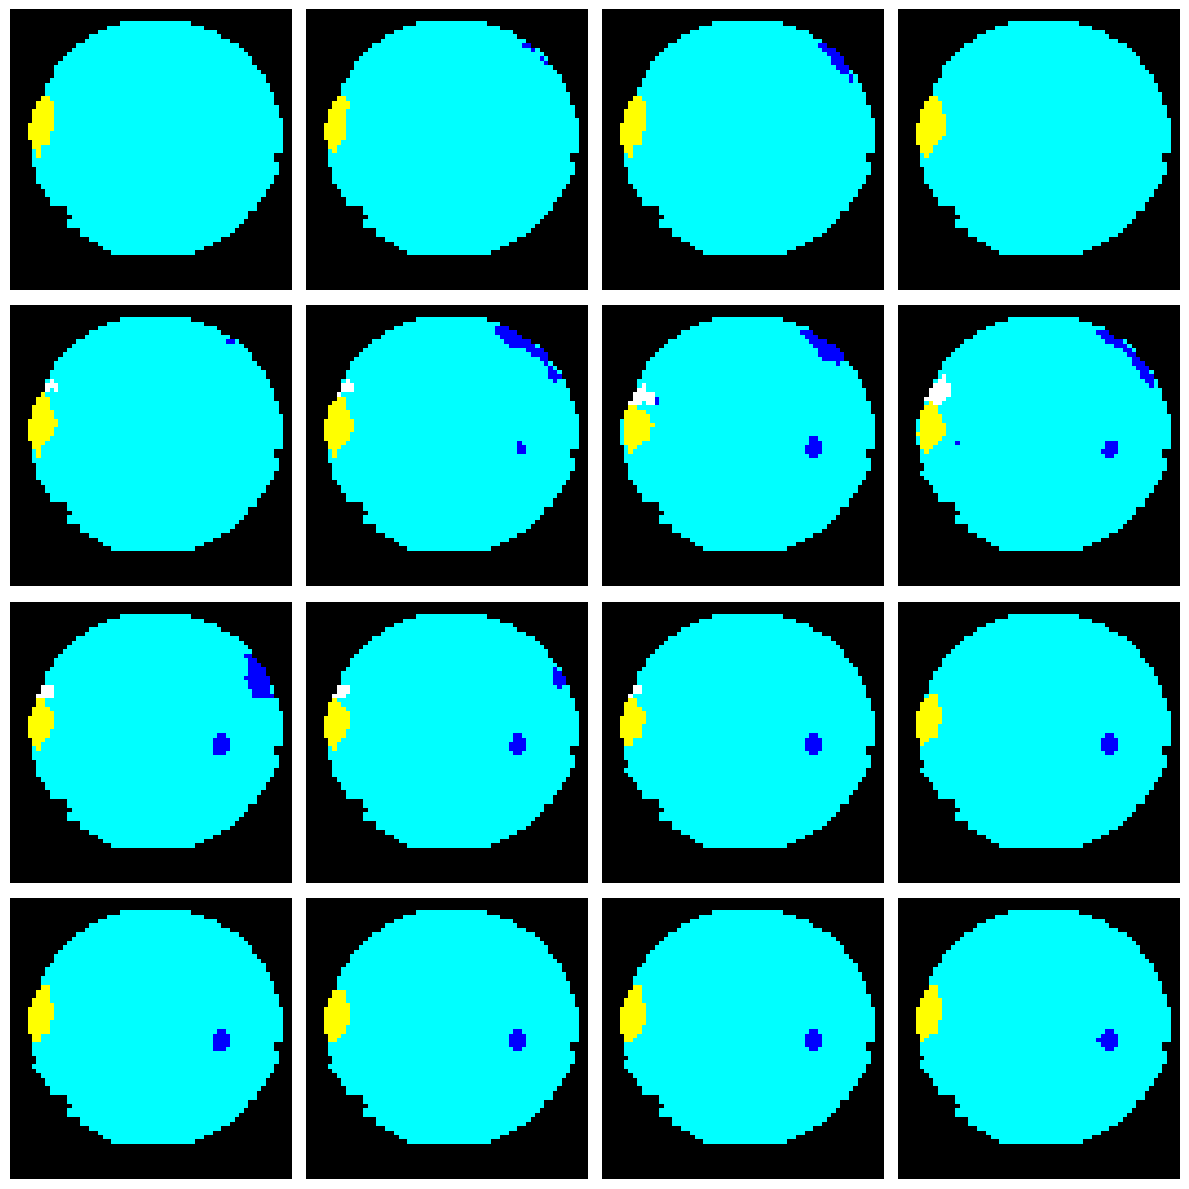

In [ ]:
for idx, (videos, targets) in enumerate(train_loader):
    print(idx)
    print(videos.shape)
    show(videos[1].data.cpu())
    break

## Model

In [ ]:
torch.cuda.empty_cache()

N_VALUES_CLOUD_MASK = 5

hidden_dims = [128, 128, 64]
kernel_size = (3, 3)
n_layers = 3
clstm = ConvLSTMmodels.SegmentedConvLSTMNet(hidden_dims, kernel_size, n_layers, device, n_channels=N_VALUES_CLOUD_MASK, batch_normalization=True)
lr = 1e-3

last_epoch = 0
if os.path.exists(output_path):
    clstm.load_state_dict(torch.load(output_path, map_location='cpu'))
    last_epoch = 50
    lr = 1e-4
else:
    print('No states loaded')

In [ ]:
#print(clstm)

In [ ]:
from importlib import reload
import ConvLSTMmodels
reload(ConvLSTMmodels)

<module 'ConvLSTMmodels' from '/content/gdrive/MyDrive/Universidad/VIU/TFM/notebooks/ConvLSTM/ConvLSTMmodels.py'>

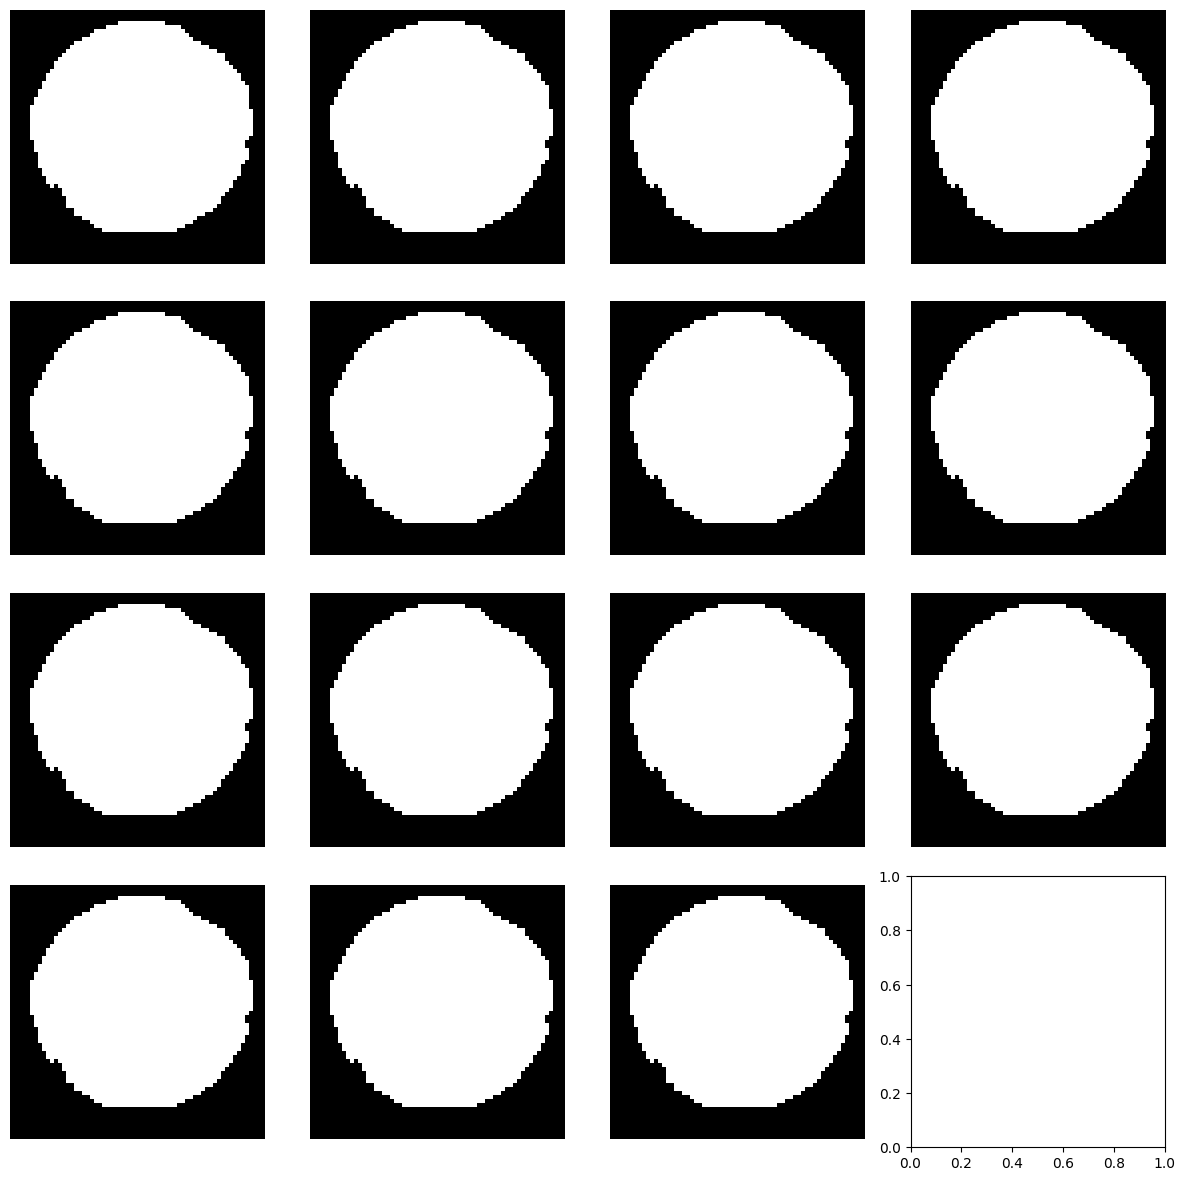

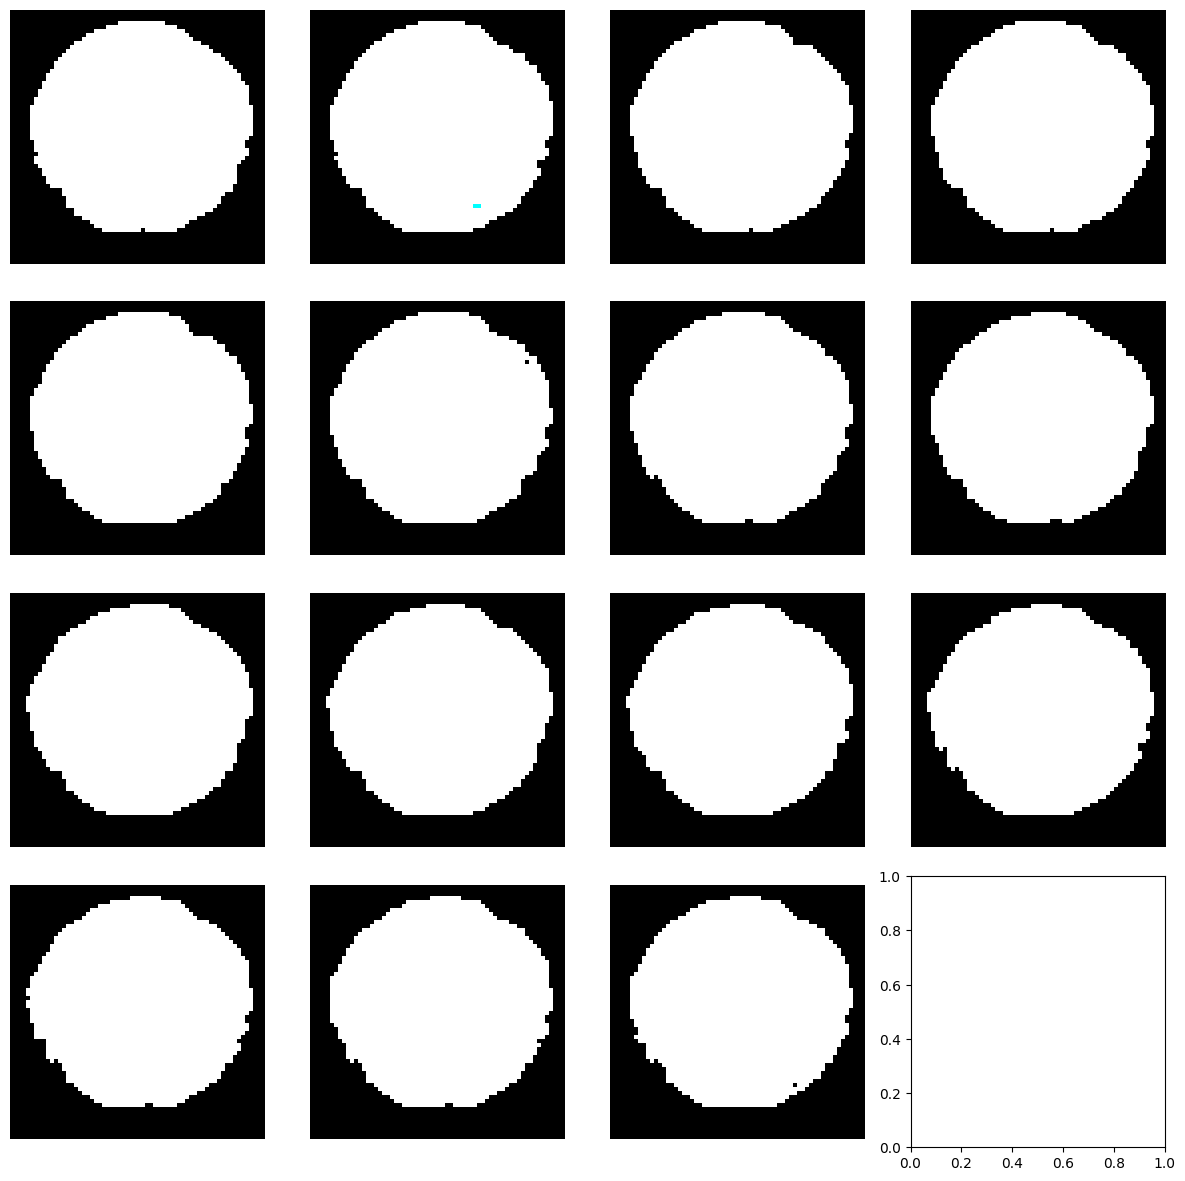

In [ ]:
with torch.no_grad():
    input_video, target_video = train_dataset[randint(1, 5000)]
    pred = clstm(input_video.unsqueeze(0), 15).squeeze(0)
    show(pred.data.cpu())
    show(target_video.data.cpu())

## Training

In [ ]:
torch.cuda.empty_cache()
loss_function = nn.MSELoss()
#loss_function = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(clstm.parameters(), lr=lr)
epochs = 50

scheduler_enc = ReduceLROnPlateau(optimizer, mode='min', patience=2,factor=0.1)
eval_every = 3 #5

# Scheduled sampling parameters
#initial_teacher_forcing_ratio = 1.0
#final_teacher_forcing_ratio = 0
#scheduled_sampling_decay = 0.1  # decay rate per epoch

clstm.train()

for epoch in range(last_epoch, epochs):
    torch.cuda.empty_cache()
    #teacher_forcing_ratio = final_teacher_forcing_ratio + (initial_teacher_forcing_ratio - final_teacher_forcing_ratio) * math.exp(-scheduled_sampling_decay * epoch)
    teacher_forcing_ratio = np.maximum(0 , 1 - epoch * 0.03)
    print(f"Epoch[{epoch+1}/{epochs}] teacher_forcing_ratio: {teacher_forcing_ratio}")
    for idx, (videos, targets) in enumerate(train_loader):
        #clstm.zero_grad()
        outputs = clstm(videos, targets.size(1), targets, teacher_forcing_ratio, True)
        targets = torch.cat([videos[:, 1:], targets], 1)
        loss = loss_function(outputs, targets)
        outputs = None
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if idx % 10 == 0:
            to_print = (
                f"Epoch[{epoch+1}/{epochs}] B[{idx+1}/{len(train_loader)}]"
                f" Loss: {loss.data.item()/bs:.4g} "
            )
            print(to_print)
    if (epoch+1) % eval_every == 0:
        with torch.no_grad():
            loss = 0
            clstm.eval()
            for idx, (videos, targets) in enumerate(test_loader):
                outputs = clstm(videos, targets.size(1))
                lossp = loss_function(outputs, targets)
                loss += lossp.item()
                lossp = None
                outputs = None
            scheduler_enc.step(loss)
            print(f"Last learning rate: {scheduler_enc.get_last_lr()}")
        clstm.train()
    torch.save(clstm.state_dict(), output_path)

Streaming output truncated to the last 5000 lines.
Epoch[28/50] B[1581/2223] Loss: 0.0002018 
Epoch[28/50] B[1591/2223] Loss: 0.0001329 
Epoch[28/50] B[1601/2223] Loss: 2.473e-05 
Epoch[28/50] B[1611/2223] Loss: 0.0002603 
Epoch[28/50] B[1621/2223] Loss: 0.0003862 
Epoch[28/50] B[1631/2223] Loss: 0.0005704 
Epoch[28/50] B[1641/2223] Loss: 0.0007932 
Epoch[28/50] B[1651/2223] Loss: 0.001215 
Epoch[28/50] B[1661/2223] Loss: 0.0001173 
Epoch[28/50] B[1671/2223] Loss: 0.0001806 
Epoch[28/50] B[1681/2223] Loss: 0.0009232 
Epoch[28/50] B[1691/2223] Loss: 2.619e-05 
Epoch[28/50] B[1701/2223] Loss: 0.0004268 
Epoch[28/50] B[1711/2223] Loss: 0.0003778 
Epoch[28/50] B[1721/2223] Loss: 0.0001866 
Epoch[28/50] B[1731/2223] Loss: 0.000172 
Epoch[28/50] B[1741/2223] Loss: 0.000314 
Epoch[28/50] B[1751/2223] Loss: 0.0003482 
Epoch[28/50] B[1761/2223] Loss: 3.518e-05 
Epoch[28/50] B[1771/2223] Loss: 0.001234 
Epoch[28/50] B[1781/2223] Loss: 0.0003169 
Epoch[28/50] B[1791/2223] Loss: 0.0006735 
Epoch[2

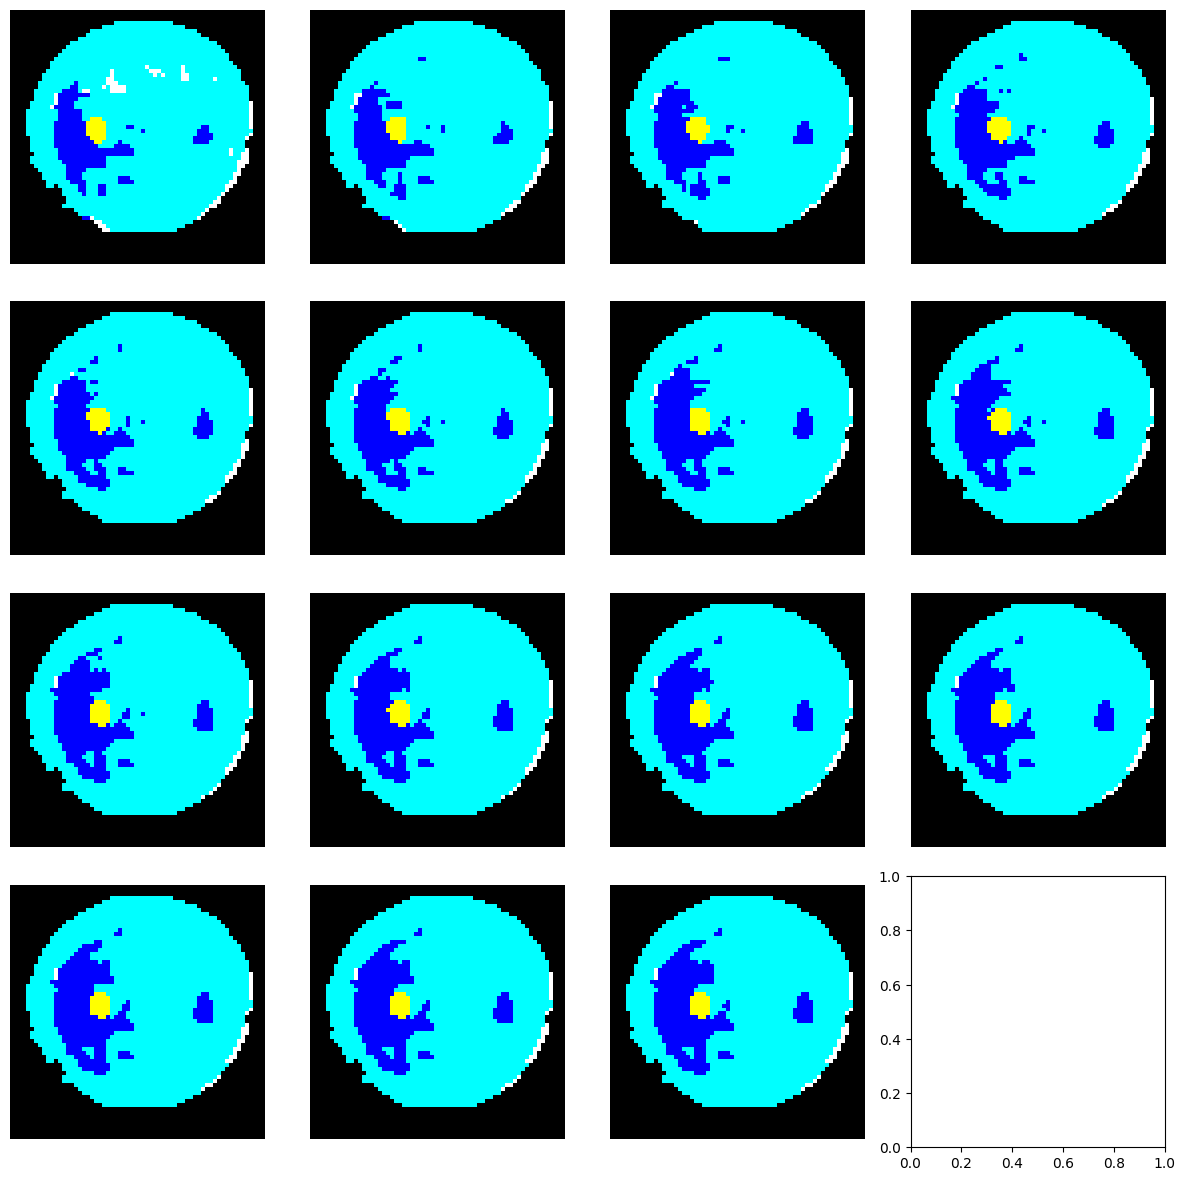

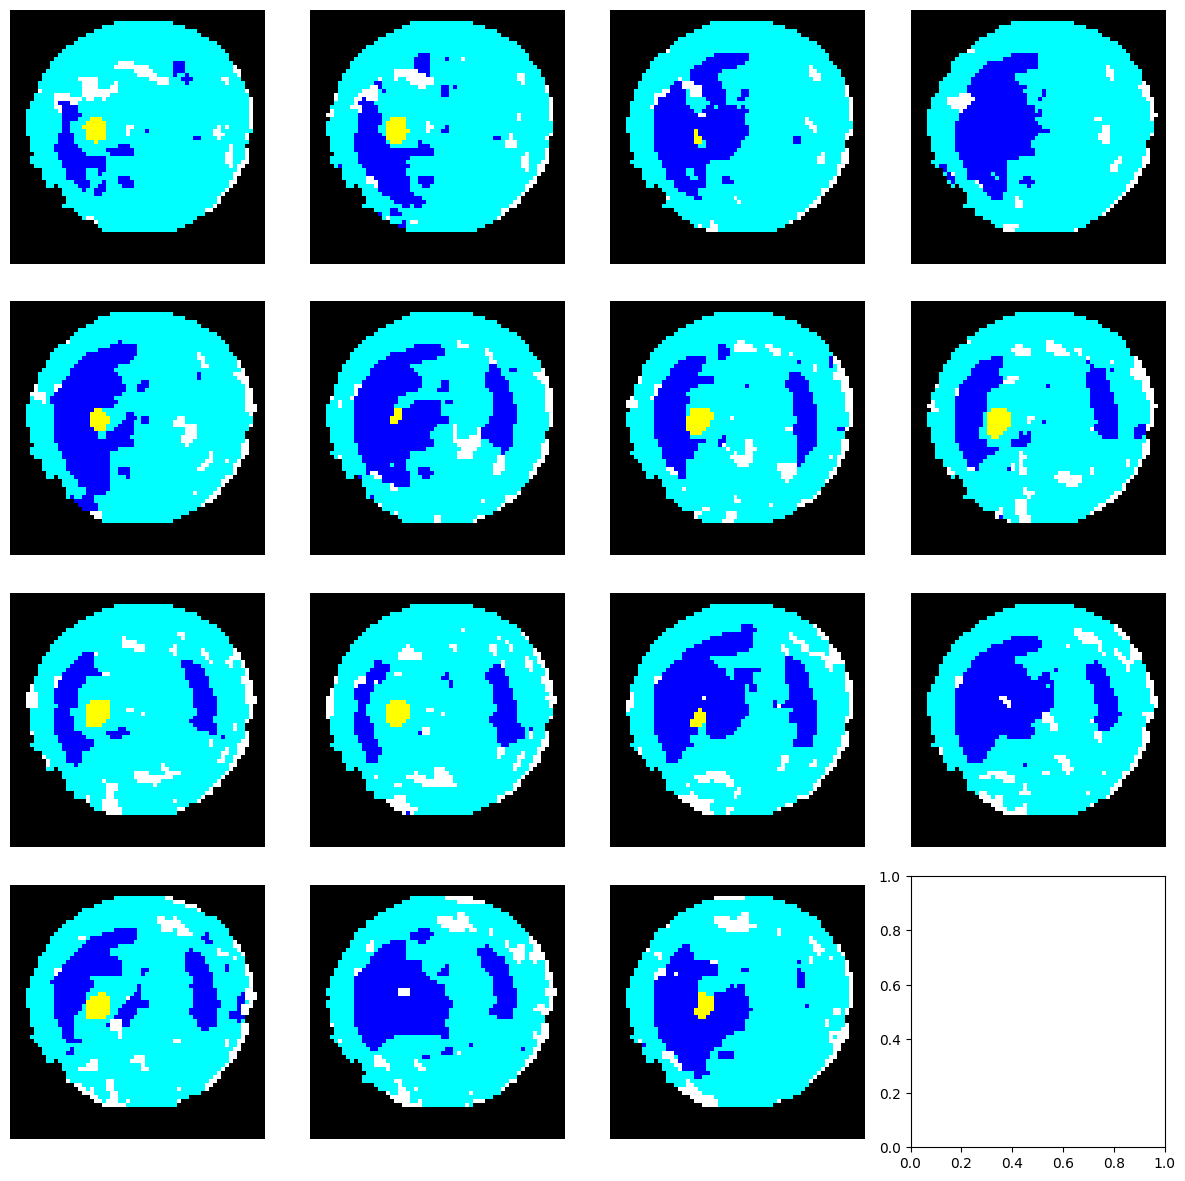

In [ ]:
with torch.no_grad():
    input_video, target_video = train_dataset[randint(1, 5000)]
    pred = clstm(input_video.unsqueeze(0), 15).squeeze(0)
    show(pred.data.cpu())
    show(target_video.data.cpu())

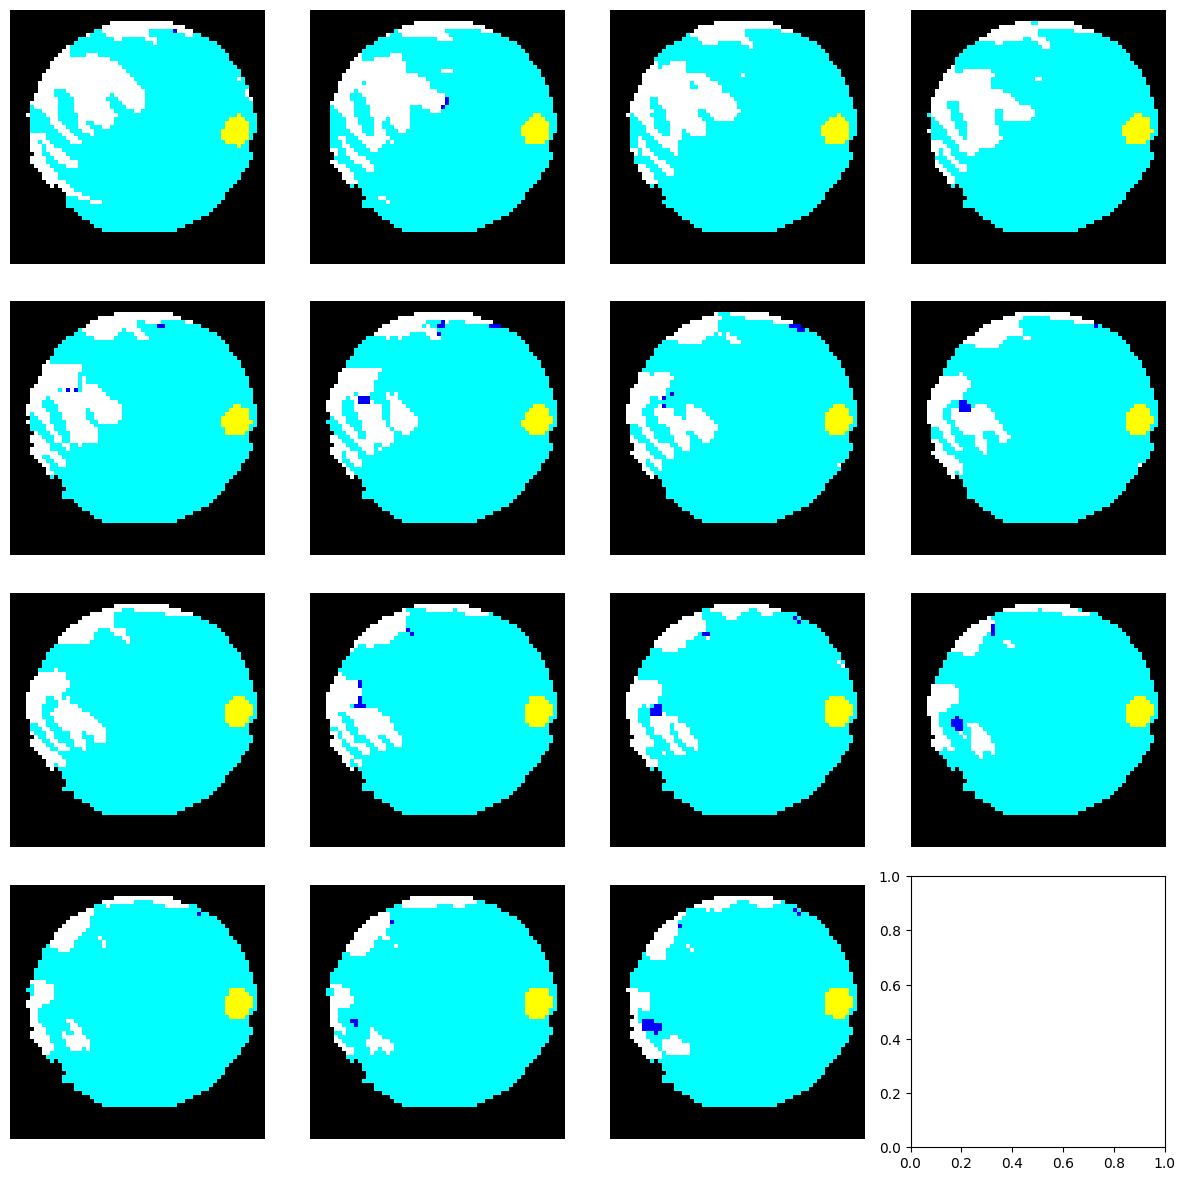

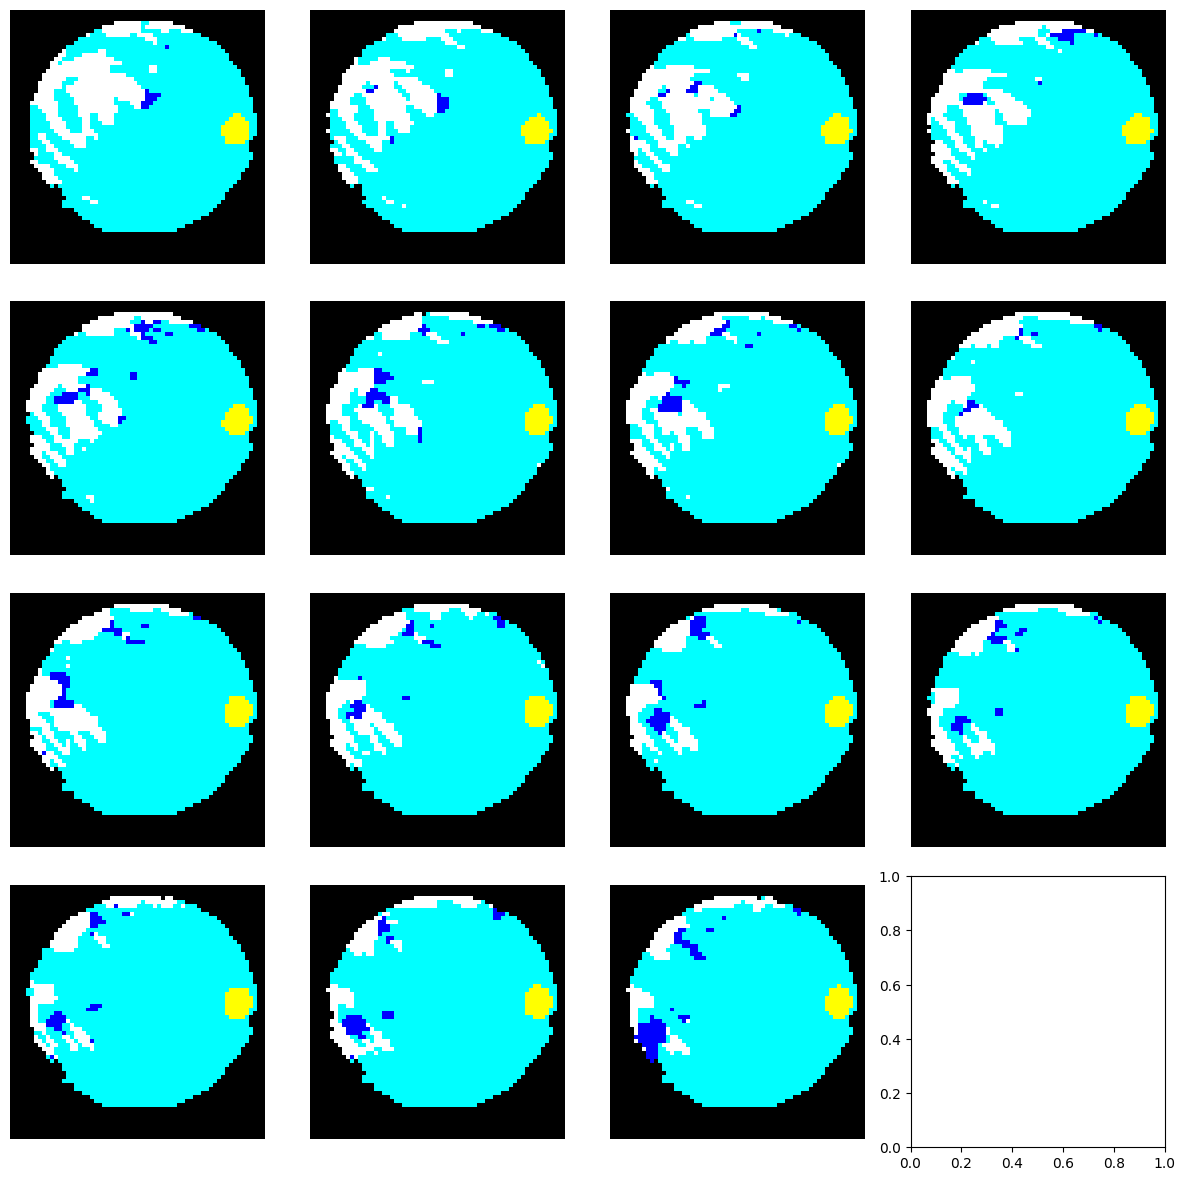

In [ ]:
# Predict with always given the true target value for previous calcs
with torch.no_grad():
    input_video, target_video = train_dataset[randint(1, 5000)]
    pred = clstm(input_video.unsqueeze(0), 15, target_video.unsqueeze(0), 1).squeeze(0)
    show(pred.data.cpu())
    show(target_video.data.cpu())

In [ ]:
with torch.no_grad():
  for i in range(0, 2000, 10):
    input_video, target_video = test_dataset[i]
    pred = clstm(input_video.unsqueeze(0), 15).squeeze(0)
    print(i)
    show(pred.data.cpu())
    show(target_video.data.cpu())

Output hidden; open in https://colab.research.google.com to view.